<a href="https://colab.research.google.com/github/ChandanCharchit/ML_Playground/blob/main/Drug_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/drug-classification/drug200.csv


* Drug Classification.
Project goal: 
To create a model capable of determining which drug type a patient should be prescirbed based on a number of features, uing a variety of classification algorithms. 

# 1. Imports

In [ ]:
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import linear_model, naive_bayes, neighbors, svm

In [ ]:
drugs = pd.read_csv('../input/drug-classification/drug200.csv')
drugs.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


the variable descriptions are as follows:

-Age: Age of the patient in years

-Sex: Sex of the patient- male or female 

-BP: Blood Pressure of patient-high, low, or normal 

-Cholesterol-Cholesterol level of the patient- normal or high

-Na-to_K: Sodium to Potassium ratio in patient's blood 

-Drug: The drug type that the patient was prescirbed- drugA,drugB,drugC,drugX or drugY

 # 2.Grouping data

we will group the Age and Sodium to Potassium Ratio(Na_to_K)values, depending on the max and min values in each column. Let's have a look at their distributions. 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

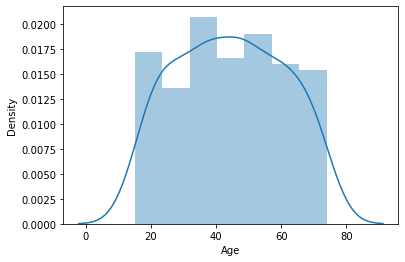

In [ ]:
sns.distplot(drugs['Age'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Na_to_K', ylabel='Density'>

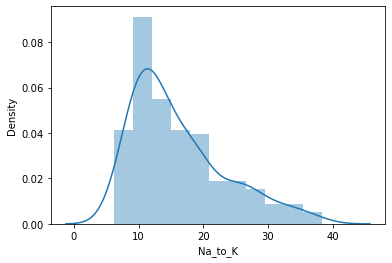

In [ ]:
sns.distplot(drugs['Na_to_K'])

In [ ]:
drugs.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


We can see here that the minimum and maximum ages are 15 and 74 respectively and the minimum and maximum sodium to potassium ratios are 6.269 and 38.247 respectively.

> **Age groups:** 
* under 30s
* 30-40
* 40-50
* 50-60
* Over 60s


> **Sodium to Potassium ratios:**
* 5-10
* 10-15
* 15-20
* 20-25
* 25-30
* 30+

In [ ]:
age_groups = []
for i in drugs['Age']:
    if i <= 30:
        age_groups.append('0-30')
    if i > 30 and i <= 40:
        age_groups.append('30-40')
    if i > 40 and i <= 50:
        age_groups.append('40-50')
    if i > 50 and i <= 60:
        age_groups.append('50-60')
    if i > 60:
        age_groups.append('60+')

drugs['AgeGroup'] = age_groups

In [ ]:
na_to_k_groups = []
for i in drugs["Na_to_K"]:
    if i <= 10:
        na_to_k_groups.append('5-10')
    if i > 10 and i <= 15:
        na_to_k_groups.append('10-15')
    if i > 15 and i <= 20:
        na_to_k_groups.append('15-20')
    if i > 20 and i <= 25:
        na_to_k_groups.append('20-25')
    if i > 25 and i <= 30:
        na_to_k_groups.append('25-30')
    if i > 30:
        na_to_k_groups.append('30+')

drugs['Na_to_K_groups'] = na_to_k_groups

In [ ]:
drugs = drugs[['AgeGroup','Sex','BP','Cholesterol','Na_to_K_groups','Drug']]
drugs.head()

,AgeGroup,Sex,BP,Cholesterol,Na_to_K_groups,Drug
0,0-30,F,HIGH,HIGH,25-30,DrugY
1,40-50,M,LOW,HIGH,10-15,drugC
2,40-50,M,LOW,HIGH,10-15,drugC
3,0-30,F,NORMAL,HIGH,5-10,drugX
4,60+,F,LOW,HIGH,15-20,DrugY


# 3.Visualising tha variable distributions

<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

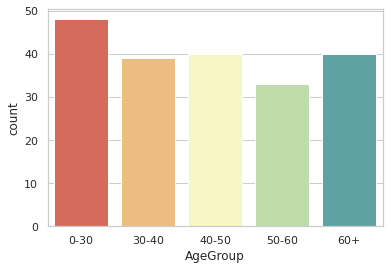

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x="AgeGroup", data=drugs, palette='Spectral', order=['0-30', '30-40', '40-50', '50-60', '60+'])

<AxesSubplot:xlabel='Sex', ylabel='count'>

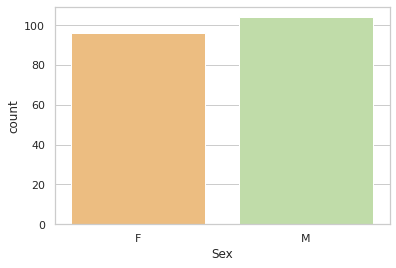

In [ ]:
sns.countplot(x='Sex', data = drugs, palette='Spectral')

<AxesSubplot:xlabel='BP', ylabel='count'>

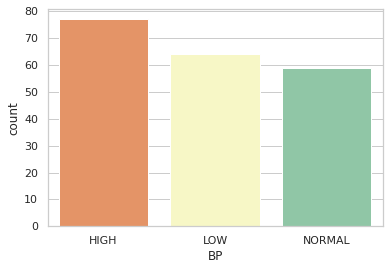

In [ ]:
sns.countplot(x="BP", data=drugs, palette='Spectral')

<AxesSubplot:xlabel='Cholesterol', ylabel='count'>

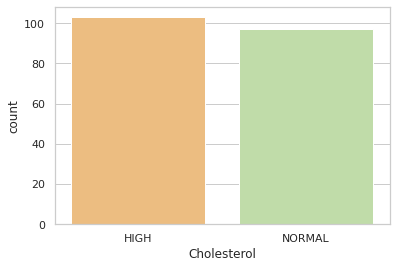

In [ ]:
sns.countplot(x="Cholesterol", data=drugs, palette='Spectral')

<AxesSubplot:xlabel='Na_to_K_groups', ylabel='count'>

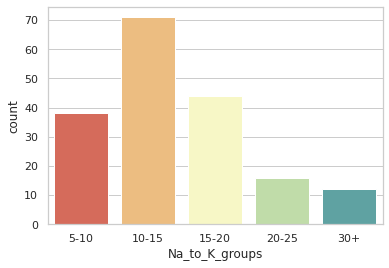

In [ ]:
sns.countplot(x='Na_to_K_groups', data=drugs, palette='Spectral', order = ['5-10','10-15','15-20','20-25','30+'])

<AxesSubplot:xlabel='Drug', ylabel='count'>

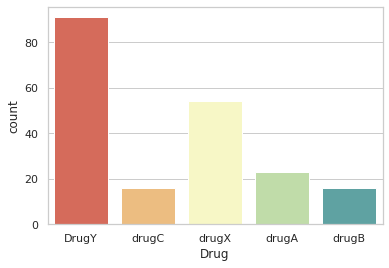

In [ ]:
sns.countplot(x="Drug", data=drugs, palette='Spectral')


The drug frequencies are very unbalanced. For a classification problem it would be ideal to have similar numbers of the trget variable. Therefore we will use SMOTE(Synthetic Minority Oversampling Technique). SMOTE will oversample drugA, drugB, drugC and drugX to have the same numver of samples as DrugY. The systhetic aspect of this oversampling technique helps to avoid overfitting, as it's not just repeating existing data. First we need to split the dataset into training and testing sets and transform the data into dummies.

In [ ]:
x, y = drugs.values[:, :-1], drugs.values[:, -1]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.33)

In [ ]:
x_train = pd.get_dummies(pd.DataFrame(x_train))
x_test = pd.get_dummies(pd.DataFrame(x_test))

We're only using SMOTE on the training data. The synthetic data shouldn't be so similar to the orginal data that it causes overfitting, but by only oversampling the training data, we will know it if does

In [ ]:
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

[Text(0.5, 0, 'Drug')]

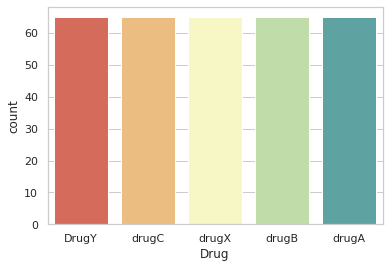

In [ ]:
ax = sns.countplot(x=y_train, data=drugs, palette='Spectral')
ax.set(xlabel='Drug')

In [ ]:
print("ORIGINAL dataset:", len(drugs), "\n EXTENDED dataset:", len(y))

ORIGINAL dataset: 200 
 EXTENDED dataset: 200


Dataset has been extended by 255 

# 4. Logistic Regression 

In [ ]:
log_reg = linear_model.LogisticRegression(max_iter = 5000)
log_reg.fit(x_train, y_train)
log_reg_acc = 100*log_reg.score(x_test, y_test)
print('Logistic Regression Predictions: \n', log_reg.predict(x_test), '\n Accuracy:', log_reg_acc, '%')

Logistic Regression Predictions: 
 ['DrugY' 'drugC' 'DrugY' 'drugC' 'DrugY' 'drugX' 'DrugY' 'drugC' 'drugB'
 'drugB' 'drugC' 'drugA' 'drugX' 'DrugY' 'drugA' 'drugX' 'DrugY' 'drugX'
 'drugX' 'DrugY' 'DrugY' 'DrugY' 'drugX' 'drugA' 'drugA' 'DrugY' 'DrugY'
 'drugX' 'DrugY' 'DrugY' 'drugB' 'drugX' 'drugX' 'drugX' 'drugA' 'drugC'
 'drugC' 'drugA' 'DrugY' 'drugX' 'drugX' 'drugC' 'drugX' 'drugB' 'DrugY'
 'DrugY' 'DrugY' 'DrugY' 'drugX' 'drugX' 'DrugY' 'DrugY' 'drugA' 'DrugY'
 'drugX' 'drugA' 'drugX' 'DrugY' 'drugB' 'drugX' 'drugA' 'drugX' 'DrugY'
 'DrugY' 'DrugY' 'DrugY'] 
 Accuracy: 100.0 %


# 5. Gaussian Naive Bayes 

In [ ]:
nb = naive_bayes.GaussianNB()
nb.fit(x_train, y_train)
nb_acc = 100*nb.score(x_test, y_test)
print('Naive Bayes Predictions: \n', nb.predict(x_test), '\n Accuracy:', nb_acc, '%')


Naive Bayes Predictions: 
 ['DrugY' 'drugC' 'DrugY' 'drugC' 'DrugY' 'drugX' 'DrugY' 'drugC' 'drugB'
 'drugB' 'drugC' 'drugA' 'drugX' 'DrugY' 'drugA' 'drugX' 'DrugY' 'drugX'
 'drugX' 'DrugY' 'DrugY' 'DrugY' 'drugX' 'drugA' 'drugA' 'DrugY' 'DrugY'
 'drugX' 'DrugY' 'DrugY' 'drugB' 'drugX' 'drugX' 'drugX' 'drugA' 'drugC'
 'drugC' 'drugA' 'DrugY' 'drugX' 'drugX' 'drugC' 'drugX' 'drugB' 'DrugY'
 'DrugY' 'DrugY' 'DrugY' 'drugX' 'drugX' 'DrugY' 'DrugY' 'drugA' 'DrugY'
 'drugX' 'drugA' 'drugX' 'DrugY' 'drugB' 'drugX' 'drugA' 'drugX' 'DrugY'
 'DrugY' 'DrugY' 'DrugY'] 
 Accuracy: 100.0 %


# 6. K-Nearest Neighbours

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=25)
knn.fit(x_train, y_train)
knn_acc = 100*knn.score(x_test, y_test)
print('K-Nearest Neighbours Predictions: \n', knn.predict(x_test), '\n Accuracy:', knn_acc, '%')

K-Nearest Neighbours Predictions: 
 ['DrugY' 'drugC' 'DrugY' 'drugC' 'DrugY' 'drugX' 'drugX' 'drugC' 'DrugY'
 'drugB' 'drugC' 'DrugY' 'drugX' 'DrugY' 'DrugY' 'drugX' 'DrugY' 'drugX'
 'drugX' 'DrugY' 'DrugY' 'DrugY' 'drugX' 'drugA' 'drugA' 'DrugY' 'DrugY'
 'drugX' 'DrugY' 'DrugY' 'drugB' 'drugX' 'DrugY' 'drugX' 'drugA' 'drugX'
 'drugX' 'DrugY' 'DrugY' 'drugX' 'drugX' 'drugC' 'drugX' 'drugB' 'DrugY'
 'DrugY' 'DrugY' 'DrugY' 'DrugY' 'drugX' 'DrugY' 'DrugY' 'drugA' 'DrugY'
 'drugX' 'drugX' 'drugX' 'DrugY' 'DrugY' 'drugX' 'DrugY' 'drugX' 'DrugY'
 'DrugY' 'DrugY' 'DrugY'] 
 Accuracy: 81.81818181818183 %


# 7. Support Vector Machine

In [ ]:
svm =svm.SVC(kernel='linear')
svm.fit(x_train, y_train)
svm_acc = 100*svm.score(x_test, y_test)
print('SVM Predictions: \n', svm.predict(x_test), '\n Accuracy:', svm_acc, '%')

SVM Predictions: 
 ['DrugY' 'drugC' 'DrugY' 'drugC' 'DrugY' 'drugX' 'DrugY' 'drugC' 'drugB'
 'drugB' 'drugC' 'drugA' 'drugX' 'DrugY' 'drugA' 'drugX' 'DrugY' 'drugX'
 'drugX' 'DrugY' 'DrugY' 'DrugY' 'drugX' 'drugA' 'drugA' 'DrugY' 'DrugY'
 'drugX' 'DrugY' 'DrugY' 'drugB' 'drugX' 'drugX' 'drugX' 'drugA' 'drugC'
 'drugC' 'drugA' 'DrugY' 'drugX' 'drugX' 'drugC' 'drugX' 'drugB' 'DrugY'
 'DrugY' 'DrugY' 'DrugY' 'drugX' 'drugX' 'DrugY' 'DrugY' 'drugA' 'DrugY'
 'drugX' 'drugA' 'drugX' 'DrugY' 'drugB' 'drugX' 'drugA' 'drugX' 'DrugY'
 'DrugY' 'DrugY' 'DrugY'] 
 Accuracy: 100.0 %


# 8. Summary

In [ ]:
pd.DataFrame(data={'Model': ['Logistic Regression','Gaussian Naive Bayes', 'K_Nearest Neighbours', 'Support Vector Machine(SVM)'], 'Accuracy %':[log_reg_acc, nb_acc, knn_acc, svm_acc]})

,Model,Accuracy %
0,Logistic Regression,100.000000
1,Gaussian Naive Bayes,100.000000
2,K_Nearest Neighbours,81.818182
3,Support Vector Machine(SVM),100.000000


# 9. Conclusion

Logistic Regression, Naive Bayes and SVM all successfully predicted 100% of the drug types that the patients should be assigned. K-Nearest Neighbours had a much lower success rate of only 77%. This makes sense as KNN is known as a 'Lazy Learner' meaning it doesn't actually 'learn' anything in the training period - it just stores training data. Nevertheless, the other models were successful!

In [ ]:
df1 = pd.read_csv('/kaggle/input/drug-classification/drug200.csv')
df1.to_csv('Drug Classification100',index = False)